# ***Image Classification with a ConvNet***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

### Data import and pre-processing

In [3]:
def read_batch(filename):
    """
    Reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files.
    """
    # Load a batch of training data from filename
    cifar_dir = 'data/cifar-10-batches-py/'
    with open(cifar_dir + filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

    # Extract the image data and cast to float from the dict dictionary
    X = dict[b'data'].astype(np.float64) / 255.0

    # Transpose X so each column corresponds to an image
    X = X.transpose()

    # Extract the labels
    y = np.array(dict[b'labels'])

    # Perform one-hot encoding
    Y = np.zeros((10, X.shape[1]), dtype=np.float64)
    Y[y, np.arange(X.shape[1])] = 1

    return X, Y, y

def normalize(X, mean_X, std_X):
    """
    Normalize the data set with respect to the mean and standard deviation values from the training set.
    """
    X -= mean_X
    X /= std_X
    
    return X

In [4]:
# Read all the batches
X_1, Y_1, y_1 = read_batch('data_batch_1')
X_2, Y_2, y_2 = read_batch('data_batch_2')
X_3, Y_3, y_3 = read_batch('data_batch_3')
X_4, Y_4, y_4 = read_batch('data_batch_4')
X_5, Y_5, y_5 = read_batch('data_batch_5')
X_test, Y_test, y_test = read_batch('test_batch')

# Concatenate them
X = np.hstack((X_1, X_2, X_3, X_4, X_5))
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))
y = np.hstack((y_1, y_2, y_3, y_4, y_5))

# Use 49000 samples for training
rng = np.random.default_rng(seed=42)
random_cols = rng.choice(X.shape[1], size=1000, replace=False)  # extract 1000 random indices
X_train, Y_train, y_train = np.delete(X, random_cols, axis=1), np.delete(Y, random_cols, axis=1), np.delete(y, random_cols) # keep the others for training
X_val, Y_val, y_val = X[:, random_cols], Y[:, random_cols], y[random_cols] # extract 1000 random samples for validation

# Compute mean and std vectors from the training set
mean_X = np.mean(X_train, axis=1).reshape(X_train.shape[0], 1)
std_X = np.std(X_train, axis=1).reshape(X_train.shape[0], 1)

# Pre-processing
X_train = normalize(X_train, mean_X, std_X)
X_val = normalize(X_val, mean_X, std_X)
X_test = normalize(X_test, mean_X, std_X)

## 1) Train a ConvNet classifier

### Implement convolution efficiently

In [9]:
def conv_dot(X, Fs, f):
    """
    Compute the ground truth convolutions using dot products for a given slide f.
    """
    n = X.shape[-1]
    X_ims = np.transpose(X.reshape((32, 32, 3, n), order='F'), (1, 0, 2, 3)) # images
    nf = Fs.shape[-1]
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    conv_outputs_dot = np.zeros((n_p_y, n_p_x, nf, n))

     # For each image
    for i in range(n):
        # For each sub-patch
        for y in range(n_p_y):
            for x in range(n_p_x):
                X_patch = X_ims[y * f : y * f + f, x * f : x * f + f, :, i] # extract sub-patch
                # For each filter
                for k in range(nf):
                    # Dot product between patch and filter
                    conv_outputs_dot[y, x, k, i] =  np.sum(np.multiply(X_patch, Fs[:, :, :, k]))
    return conv_outputs_dot  

def compute_MX(X, f):
    """
    Use the input data to build MX matrix for a given filters size f.
    """
    n = X.shape[-1]
    X_ims = np.transpose(X.reshape((32, 32, 3, n), order='F'), (1, 0, 2, 3)) # images
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches
    MX = np.zeros((n_p, f * f * 3, n))

    # For each image
    for i in range(n):
        # For each sub-patch
        for y in range(n_p_y):
            for x in range(n_p_x):
                l = x + y * n_p_x # sub-patch index
                X_patch = X_ims[y * f : y * f + f, x * f : x * f + f, :, i] # extract sub-patch
                MX[l, :, i] = X_patch.reshape((1, f*f*3), order='C') # build MX

    return MX
    
def conv_mat(MX, Fs, f):
    """
    Compute the convolutions efficiently using matrix product formulations for a given filters size f and an input MX.
    """
    n = MX.shape[-1]
    nf = Fs.shape[-1]
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches
    conv_outputs_mat = np.zeros((n_p, nf, n))

    # Flatten the filters
    Fs_flat = Fs.reshape((f * f *3, nf), order='C')
   
    # Compute the convolutions with Einstein summation
    conv_outputs_mat = np.einsum('ijn, jl->iln', MX, Fs_flat, optimize=True)

    return conv_outputs_mat

Debugging:

In [13]:
# Read in test data and initialize parameters
debug_file = 'debug_info.npz'
load_data = np.load(debug_file)
X = load_data['X'] # flattened images
Fs = load_data['Fs']
n = X.shape[1]
f = 4
nf = Fs.shape[-1]
n_p_y = 32 // f # number of sub-patches over y
n_p_x = 32 // f # number of sub-patches over x
n_p = n_p_y * n_p_x # total number of sub-patches
MX = compute_MX(X, f) # transform input data

# Comparison
conv_outputs_mat = conv_mat(MX, Fs, f)
conv_outputs_dot = conv_dot(X, Fs, f).reshape((n_p, nf, n), order='C')
conv_outputs_true = load_data['conv_outputs'].reshape((n_p, nf, n), order='C')
print('\nMaximum error between true and dot convolutions:', np.max(abs(conv_outputs_true - conv_outputs_dot)))
print('\nMaximum error between true and mat convolutions:', np.max(abs(conv_outputs_true - conv_outputs_mat)))


Maximum error between true and dot convolutions: 0.0

Maximum error between true and mat convolutions: 1.7763568394002505e-15


### Compute gradients

In [11]:
def ReLU(S):
    """
    Compute the ReLU function for a given input array S.
    """
    return np.maximum(0, S)
    
def softmax(S):
    """
    Compute the softmax function for a given input array S.
    """
    exp_S = np.exp(S)
    return exp_S / np.sum(exp_S, axis=0, keepdims=True)

def forward(MX, network):
    """
    Apply the network function to multiple images and return both the outputs and the intermediary activation values.
    """
    Fs_flat = network['Fs_flat'] # extract filters
    conv_b = network['conv_b'] # extract conv bias
    f = network['f'] # extract filters size
    W = network['W'] # extract weights
    b = network['b'] # extract biases
    n = MX.shape[-1] # number of samples
    nf = Fs_flat.shape[-1] # number of filters
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches
    fp_data = {} # dictionary with hidden activations and output probabilities
    
    # Convolution layer
    H = ReLU(conv_mat(MX, Fs_flat, f) + conv_b)   
    h = H.reshape((n_p*nf, n), order='C')
    fp_data['h'] = h

    # Fully-connected layers
    X1 = ReLU(np.dot(W[0], h) + b[0])
    fp_data['X1'] = X1
    S = np.dot(W[1], X1) + b[1]
    fp_data['P'] = softmax(S) # convert output to probabilities
    
    return fp_data

def backward(MX, Y, fp_data, network, lam):
    """
    Estimate, for a mini-batch, the gradients of the cost function with respect to weights, biases and filters.
    """
    n_batch = MX.shape[-1] # batch size
    Fs_flat = network['Fs_flat'] # extract filters
    f = network['f'] # extract filters size
    nf = Fs_flat.shape[-1] # number of filters
    W = network['W'] # extract weights
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches
    h = fp_data['h'] # extract convolution activations
    X1 = fp_data['X1'] # extract hidden activations
    P = fp_data['P'] # extract output probabilities
    grads = {} # dictionnary with the gradients
    grads['W'] = [None] * 2
    grads['b'] = [None] * 2

    # Backward pass
    G_batch = - (Y - P)

    # Gradients in the second fully-connected layer
    grads['W'][1] = np.dot(G_batch, X1.transpose()) / n_batch + 2 * lam * W[1]
    grads['b'][1] = np.sum(G_batch, axis=1) / n_batch
    grads['b'][1] = grads['b'][1].reshape(-1, 1) # add one dimension for computation convenience
    G_batch = np.dot(W[1].transpose(), G_batch)
    G_batch = G_batch * (X1 > 0).astype(float)

    # Gradients in the first fully-connected layer
    grads['W'][0] = np.dot(G_batch, h.transpose()) / n_batch + 2 * lam * W[0]
    grads['b'][0] = np.sum(G_batch, axis=1) / n_batch
    grads['b'][0] = grads['b'][0].reshape(-1, 1)
    G_batch = np.dot(W[0].transpose(), G_batch)
    G_batch = G_batch * (h > 0).astype(float)

    # Gradients in the convolution layer
    G_batch = G_batch.reshape((n_p, nf, n_batch), order='C') # size (n_p, nf, n_batch)
    MXt = np.transpose(MX, (1, 0, 2))
    grads['Fs_flat'] = np.einsum('ijn, jln->il', MXt, G_batch, optimize=True) / n_batch + 2 * lam * Fs_flat
    grads['conv_b'] = np.sum(G_batch, axis=(0, 2)) / (n_p * n_batch)
    grads['conv_b'] = grads['conv_b'].reshape(-1, 1)
    
    return grads

def initialize_net_he(nf, f, nh, rng):
    """
    Initialize the network's parameters with He initialization for 3072-dimensional inputs, 10-dimensional outputs, 1 convolution layer of nf filters with filters size f and 2 fully-connected layers of size nh.
    """
    # Initialize the structure
    net_params = {}
    net_params['W'] = [None] * 2
    net_params['b'] = [None] * 2

    # Initialize parameters of the convolutional layer
    conv_n_in = 3 * f * f
    net_params['Fs_flat'] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / conv_n_in), size=(3 * f * f, nf))
    net_params['conv_b'] = np.zeros((nf, 1))

    # Initialize parameters of the fully-connected layers
    n_p_y = 32 // f
    n_p_x = 32 // f
    n_p = n_p_y * n_p_x

    # First fully-connected layer: in = flattened conv output, out = nh hidden nodes
    fc_in_dim = n_p * nf
    net_params['W'][0] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / fc_in_dim), size=(nh, fc_in_dim))
    net_params['b'][0] = np.zeros((nh, 1))

    # Second fully-connected layer: in = nh, out = 10 classes
    net_params['W'][1] = rng.normal(loc=0.0, scale=np.sqrt(2.0 / nh), size=(10, nh))
    net_params['b'][1] = np.zeros((10, 1))

    # Store filters size to use it later
    net_params['f'] = f
    
    return net_params

Debugging:

In [108]:
# Read in test data and initialize parameters
debug_file = 'debug_info.npz'
load_data = np.load(debug_file)
X = load_data['X']
Y = load_data['Y']
f = 4
Fs = load_data['Fs']
nf = Fs.shape[-1]
Fs_flat = Fs.reshape((3 * f * f, nf), order='C') 
W1 = load_data['W1']
W2 = load_data['W2']
b1 = load_data['b1']
b2 = load_data['b2']
n = X.shape[1]
n_p_y = 32 // f
n_p_x = 32 // f
n_p = n_p_y * n_p_x
lam = 0
MX = compute_MX(X, f) # transform input data
network = {'Fs_flat': Fs_flat, 'W': [W1, W2], 'b': [b1, b2], 'f':f, 'conv_b':np.zeros((nf, 1))} # build network

# Comparison of forward pass
fp_data = forward(MX, network)
conv_flat_fp = fp_data['h']
conv_flat_true = load_data['conv_flat']
X1_fp = fp_data['X1']
X1_true = load_data['X1']
P_fp = fp_data['P']
P_true = load_data['P']
print('Debugging forward pass:')
print('Maximum error on convolutions:', np.max(abs(conv_flat_fp - conv_flat_true)))
print('Maximum error on X1:', np.max(abs(X1_fp - X1_true)))
print('Maximum error on P:', np.max(abs(P_fp - P_true)))

# Comparison of backward pass
grads = backward(MX, Y, fp_data, network, lam)
grad_Fs_flat = grads['Fs_flat']
grad_Fs_flat_true = load_data['grad_Fs_flat']

print('\nDebugging backward pass:')
print('Maximum error on Fs_flat gradients:', np.max(abs(grad_Fs_flat - grad_Fs_flat_true)))

Debugging forward pass:
Maximum error on convolutions: 8.881784197001252e-16
Maximum error on X1: 1.1102230246251565e-15
Maximum error on P: 8.326672684688674e-17

Debugging backward pass:
Maximum error on Fs_flat gradients: 2.7755575615628914e-16


Gradients checking with PyTorch:

In [210]:
def conv_mat_torch(MX, Fs_flat, f):
    """
    Efficiently compute convolutions using matrix multiplication with a for loop instead of einsum to handle torch tensors.
    
    """
    n = MX.shape[-1]  # number of samples
    nf = Fs_flat.shape[-1]  # number of filters
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches
    conv_outputs_mat = torch.zeros((n_p, nf, n), dtype=torch.float32) # initialize an empty tensor
    
    # Manually compute convolutions with a for loop
    for i in range(n):
        conv_outputs_mat[:, :, i] = torch.matmul(MX[:, :, i], Fs_flat)

    return conv_outputs_mat

def print_error_stats(name, err_array):
    """
    Compute error stats to perform a solid gradient check.
    """
    mean_err = np.mean(err_array)
    interval = np.std(err_array)
    print(f"{name} gradient errors:")
    print(f"Mean ± Std: {mean_err:.2e} ± {interval:.2e}")

def ComputeGradsWithTorch(MX, y, network_params):
    MXt = torch.tensor(MX, dtype=torch.float32)
    L = len(network_params['W'])
    f = network_params['f'] # extract filters size
    nf = network_params['Fs_flat'].shape[-1] # number of filters
    n = MX.shape[-1] # number of samples
    n_p_y = 32 // f # number of sub-patches over y
    n_p_x = 32 // f # number of sub-patches over x
    n_p = n_p_y * n_p_x # total number of sub-patches

    # will be computing the gradient w.r.t. these parameters   
    Fs_flat = torch.tensor(network_params['Fs_flat'], dtype=torch.float32, requires_grad=True) # filters
    W = [None] * L
    b = [None] * L    
    for i in range(L):
        W[i] = torch.tensor(network_params['W'][i], dtype=torch.float32, requires_grad=True) # weights
        b[i] = torch.tensor(network_params['b'][i], dtype=torch.float32, requires_grad=True) # biases     

    ## give informative names to these torch classes        
    apply_relu = torch.nn.ReLU()
    apply_softmax = torch.nn.Softmax(dim=0)
    
    # forward pass
    # convolution layer
    H = conv_mat_torch(MXt, Fs_flat, f)  # use a PyTorch version of conv_mat
    H = apply_relu(H)   
    h = H.view(n_p * nf, n)

    # fully-connected layers
    X1 = apply_relu(torch.matmul(W[0], h) + b[0])
    S = torch.matmul(W[1], X1) + b[1]          

    # apply SoftMax to each column of scores     
    P = apply_softmax(S)
    
    # compute the loss
    loss = torch.mean(-torch.log(P[y, np.arange(n)]))
    
    # compute the backward pass relative to the loss and the named parameters 
    loss.backward()

    # extract the computed gradients and make them numpy arrays 
    grads = {}
    grads['W'] = [None] * L
    grads['b'] = [None] * L
    for i in range(L):
        grads['W'][i] = W[i].grad.numpy()
        grads['b'][i] = b[i].grad.numpy()
        
    # filters gradient
    grads['Fs_flat'] = Fs_flat.grad.numpy()
        
    return grads

In [208]:
# Initialize a small network for the checking
n_small = 8
lam = 0.0
f = 4
nf = 4
rng = np.random.default_rng(seed=42)
small_net = initialize_net_he(nf=nf, f=f, nh=50, rng=rng)
X_small = X_train[:,0:n_small]
Y_small = Y_train[:,0:n_small]
MX_small = compute_MX(X_small, f)

fp_data = forward(MX_small, small_net)
my_grads = backward(MX_small, Y_small, fp_data, small_net, lam)
torch_grads = ComputeGradsWithTorch(MX_small, y_train[0:n_small], small_net)

# Comparison
eps = 1e-8
min_error = float("inf")
max_error = float("-inf")
# Iterate over layers
for l, (w_a, b_a, w_n, b_n) in enumerate(zip(my_grads['W'], my_grads['b'], torch_grads['W'], torch_grads['b'])):
    print(f"\nFC layer {l+1}:")
    
    # Errors on weight gradients
    abs_diff_w = np.abs(w_a - w_n)
    denominator_w = np.maximum(eps, np.abs(w_a) + np.abs(w_n))
    err_w = abs_diff_w / denominator_w
    print_error_stats("Weights", err_w)

    # Errors on bias gradients
    abs_diff_b = np.abs(b_a - b_n)
    denominator_b = np.maximum(eps, np.abs(b_a) + np.abs(b_n))
    err_b = abs_diff_b / denominator_b
    print_error_stats("Bias", err_b)

# Errors on filter gradients
print('\nConv layer:')
f_a = my_grads['Fs_flat']
f_n = torch_grads['Fs_flat']
abs_diff_f = np.abs(f_a - f_n)
denominator_f = np.maximum(eps, np.abs(f_a) + np.abs(f_n))
err_f = abs_diff_f / denominator_f
print_error_stats("Filter", err_f)


FC layer 1:
Weights gradient errors:
Mean ± Std: 3.82e-07 ± 4.49e-06
Bias gradient errors:
Mean ± Std: 9.10e-08 ± 8.40e-08

FC layer 2:
Weights gradient errors:
Mean ± Std: 2.22e-07 ± 5.50e-07
Bias gradient errors:
Mean ± Std: 9.45e-08 ± 1.27e-07

Conv layer:
Filter gradient errors:
Mean ± Std: 3.36e-07 ± 1.10e-06


### Train small networks with cyclic learning rates

In [13]:
def compute_loss(P, y):
    """
    Compute the mean cross-entropy loss of the network's predictions relative to the ground truth labels.
    """
    P_y = P[y, np.arange(P.shape[1])] # extract the probabilitu=ies of the true labels
    return np.mean(-np.log(P_y))

def compute_accuracy(P, y):
    """
    Compute the accuracy of the network's predictions.
    """
    predicted_classes = np.argmax(P, axis=0)
    correct_predictions = np.sum(predicted_classes == y)  # count correct predictions
    acc = correct_predictions / len(y) 
    return acc

def compute_cyclical_eta(t, n_s, eta_min, eta_max):
    """
    Compute the cyclical learning rate.
    """
    l = t // (2 * n_s)  # compute the cycle indice l
    lower_bound = 2 * l * n_s
    upper_bound = (2 * l + 1) * n_s

    if lower_bound <= t < upper_bound:
        eta = eta_min + (t - lower_bound) * (eta_max - eta_min) / n_s
    else:
        eta = eta_max - (t - upper_bound) * (eta_max - eta_min) / n_s
    return eta
  
def minibatchGD(MX_train, Y_train, y_train, MX_val, Y_val, y_val, GDparams, init_net, lam, rng, increase_step=False, plot_per=500, verbose=True, plot_learning=True):
    """
    Perform mini-batch gradient descent with cyclical learning rate.
    """
    n = MX_train.shape[-1] # total number of samples
    n_batch, eta_min, eta_max, n_s, n_cycle = GDparams['n_batch'], GDparams['eta_min'], GDparams['eta_max'], GDparams['n_s'], GDparams['n_cycle']
    n_updates_total = n_s * (2 ** (n_cycle + 1) - 2) if increase_step else 2 * n_s * n_cycle # total number of updates
    n_updates_per_epoch = n // n_batch # number of updates per epoch
    network =  copy.deepcopy(init_net) # network initialization
    t_ranged = 0 # will always stay in range [1, 2 * n_s] to handle the increase of n_s
   
    # Initialize tracking
    train_losses = []  # to store loss
    train_accuracies = []  # to store accuracy
    val_losses = []  # to store validation loss
    val_accuracies = []  # to store validation accuracy
    steps_plot = [] # to store update steps

    for t in range(1, n_updates_total + 1):
        # Reshuffle at the start of each epoch
        if (t - 1) % n_updates_per_epoch == 0:
            shuffled_indices = rng.permutation(n)
            MX_shuffled = MX_train[:, :, shuffled_indices]
            Y_shuffled = Y_train[:, shuffled_indices]

        # Generate a random mini-batch of size n_batch
        j = (t - 1) % n_updates_per_epoch
        j_start = j * n_batch
        j_end = (j + 1) * n_batch
        inds = range(j_start, j_end)
        MX_batch = MX_shuffled[:, :, inds]
        Y_batch = Y_shuffled[:, inds]

        # Forward pass: compute hidden activations and probabilities for the batch samples
        fp_data_batch = forward(MX_batch, network)

        # Backward pass: compute estimations of the gradient based on the batch samples
        grad_batch = backward(MX_batch, Y_batch, fp_data_batch, network, lam)
        
        # Learning rate computation
        # Step size increasing
        if (t_ranged + 1) % (2 * n_s) == 0 and increase_step: # if a cycle has been achieved and we want n_s to be increased
            n_s *= 2 # doubled after each cycle
            t_ranged = 1 # reset t_ranged
        else:
            t_ranged += 1 # increment t_ranged because the cycle is not finished, or we don't want n_s to be increased
        eta = compute_cyclical_eta(t_ranged, n_s, eta_min, eta_max)

        # Update parameters with cyclical learning rate for each layer separately
        # Fully-connected layers
        for l in range(len(network['W'])):
            network['W'][l] -= eta * grad_batch['W'][l]
            network['b'][l] -= eta * grad_batch['b'][l]

        # Convolutional layer
        network['Fs_flat'] -= eta * grad_batch['Fs_flat']
        network['conv_b'] -= eta * grad_batch['conv_b']
        
        # Compute losses and accuracies with the given period
        if (t == 1 or t % plot_per == 0 or t == n_updates_total) and plot_learning:
            # Compute training loss and accuracy
            P_train = forward(MX_train, network)['P']
            train_loss = compute_loss(P_train, y_train)
            train_acc = compute_accuracy(P_train, y_train)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # Compute validation loss and accuracy
            P_val = forward(MX_val, network)['P']
            val_loss = compute_loss(P_val, y_val)
            val_acc = compute_accuracy(P_val, y_val)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            steps_plot.append(t)

            if verbose:
                print(f"Update step {t} || Training loss = {train_loss} || Training accuracy = {train_acc}")

    if plot_learning:
        # Plot loss over update steps
        plt.plot(steps_plot, train_losses, label='Training Loss', color='g')
        plt.plot(steps_plot, val_losses, label='Test Loss', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.ylim(0.25, 2.7)
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_f{network['f']}_nf{network['Fs_flat'].shape[-1]}_increase{increase_step}.png", dpi=300)
        plt.show()

        # Plot accuracy over update steps
        plt.plot(steps_plot, train_accuracies, label='Training Accuracy', color='g')
        plt.plot(steps_plot, val_accuracies, label='Test Accuracy', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid()
        plt.savefig(f"acc_f{network['f']}_nf{network['Fs_flat'].shape[-1]}increase{increase_step}.png", dpi=300)
        plt.show()
        
    return network

Architecture 1

In [16]:
# Network architecture
f = 2
nf = 3
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

In [18]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train,  MX_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))


Training time: 79.58 seconds

Training accuracy: 0.5438367346938775

Validation accuracy: 0.511

Test accuracy: 0.5049


Architecture 2

In [20]:
# Network architecture
f = 4
nf = 10
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

In [22]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train,  MX_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))


Training time: 80.67 seconds

Training accuracy: 0.6161224489795918

Validation accuracy: 0.563

Test accuracy: 0.5641


Architecture 3

In [31]:
# Network architecture
f = 8
nf = 40
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

In [32]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train,  MX_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))


Training time: 95.32 seconds

Training accuracy: 0.6347551020408163

Validation accuracy: 0.587

Test accuracy: 0.5859


Architecture 4

In [24]:
# Network architecture
f = 16
nf = 160
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

In [35]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train,  MX_val, Y_val, y_val, GDparams, init_net, lam, rng=rng, verbose=False, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))


Training time: 121.60 seconds

Training accuracy: 0.6297755102040816

Validation accuracy: 0.571

Test accuracy: 0.5644


### Bar charts

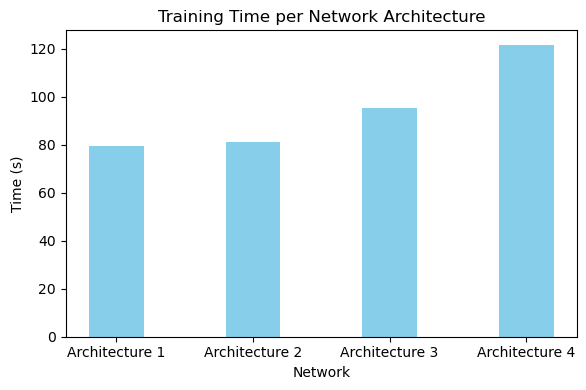

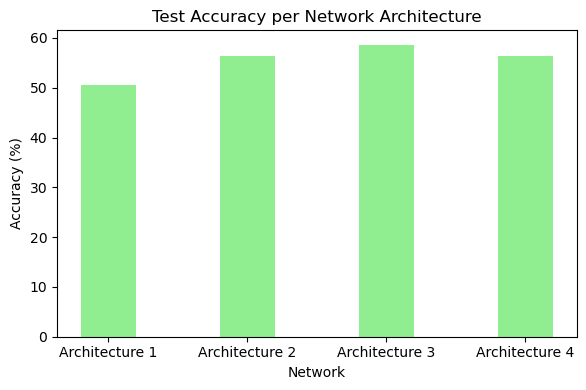

In [28]:
times = [79.58, 80.96, 95.32, 121.6]
acc = [50.49, 56.41, 58.59, 56.44]
labels = ['Architecture 1', 'Architecture 2', 'Architecture 3', 'Architecture 4']

# Bar chart for times
plt.figure(figsize=(6, 4))
plt.bar(labels, times, color='skyblue', width=0.4)
plt.title('Training Time per Network Architecture')
plt.xlabel('Network')
plt.ylabel('Time (s)')
plt.tight_layout()
plt.savefig('training_times.png')
plt.show()

# Bar chart for accuracy
plt.figure(figsize=(6, 4))
plt.bar(labels, acc, color='lightgreen', width=0.4)
plt.title('Test Accuracy per Network Architecture')
plt.xlabel('Network')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.savefig('test_accuracy.png')
plt.show()

### Train for longer with increasing step sizes

Architecture 2:

In [39]:
# Network architecture
f = 4
nf = 10
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

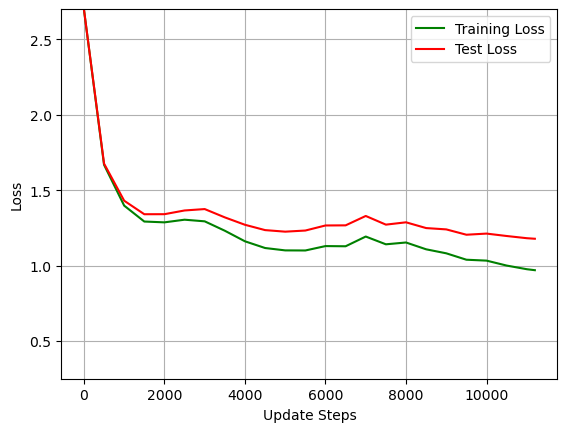

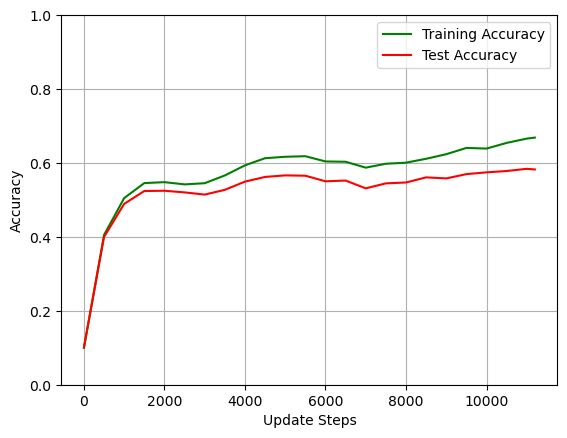


Training time: 322.06 seconds

Training accuracy: 0.6686122448979592

Validation accuracy: 0.586

Test accuracy: 0.5824


In [41]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

Architecture 3:

In [43]:
# Network architecture
f = 8
nf = 40
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

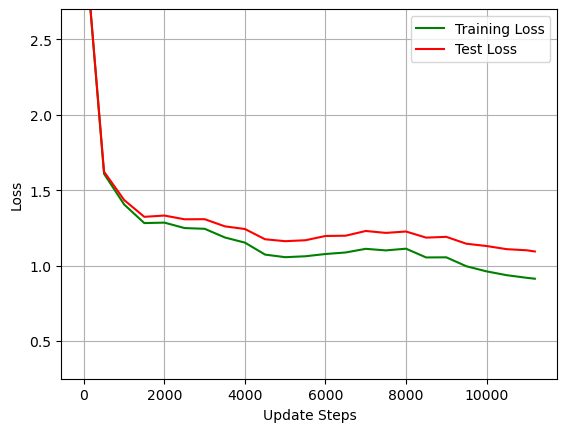

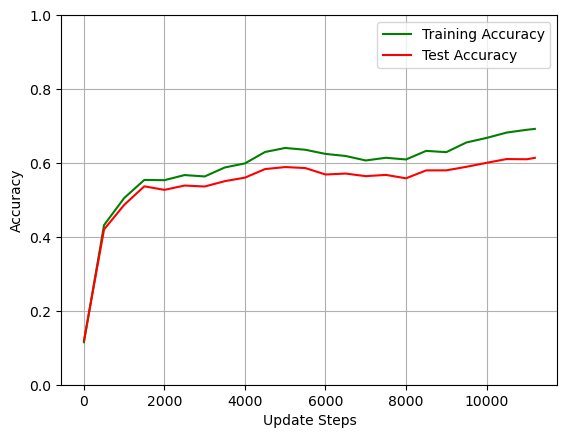


Training time: 261.13 seconds

Training accuracy: 0.692204081632653

Validation accuracy: 0.621

Test accuracy: 0.6138


In [45]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

Wider Architecture 2:

In [47]:
# Network architecture
f = 4
nf = 40
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

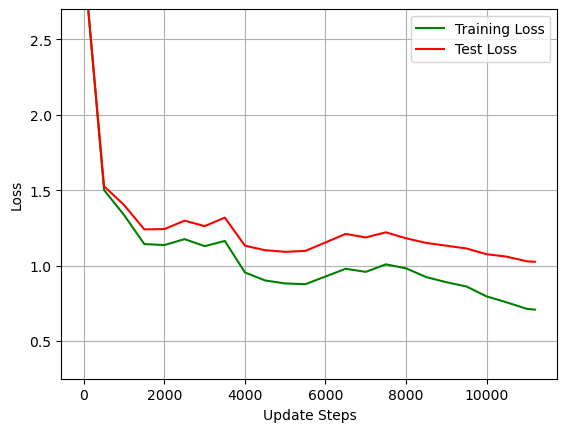

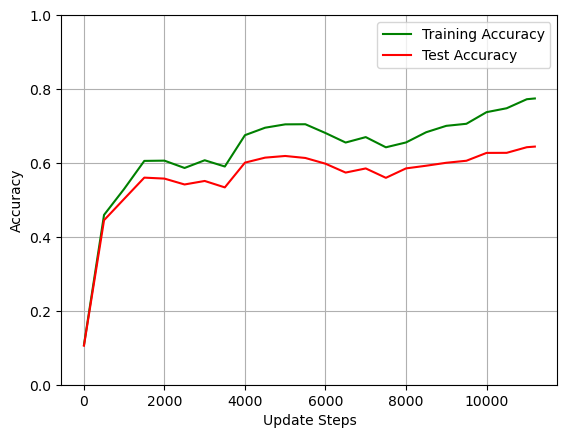


Training time: 495.18 seconds

Training accuracy: 0.7745102040816326

Validation accuracy: 0.663

Test accuracy: 0.6443


In [49]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

### Larger networks and regularization with label smoothing

In [69]:
# Network architecture
f = 4
nf = 40
nh = 300

# Hyper-parameters
n_batch = 100
n_cycle = 4
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.0025

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

Without label smooting:

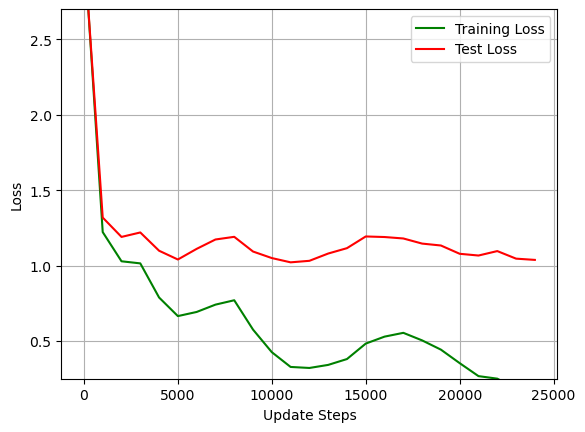

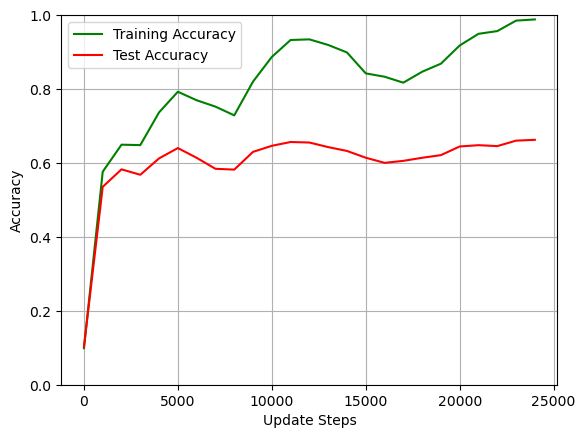


Training time: 1810.49 seconds

Training accuracy: 0.9883469387755102

Validation accuracy: 0.663

Test accuracy: 0.6626


In [55]:
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

With label smoothing:

In [15]:
def smooth_labels(Y, eps=0.1, K=10):
    """
    Smooth one-hot encoded labels for regularization purposes.
    """
    Y_smooth = np.zeros_like(Y)
    for n in range(Y.shape[1]):
        for i in range(Y.shape[0]):
            Y_smooth[i,n] = (1 - eps) if Y[i,n] == 1 else eps / (K - 1)
    return Y_smooth

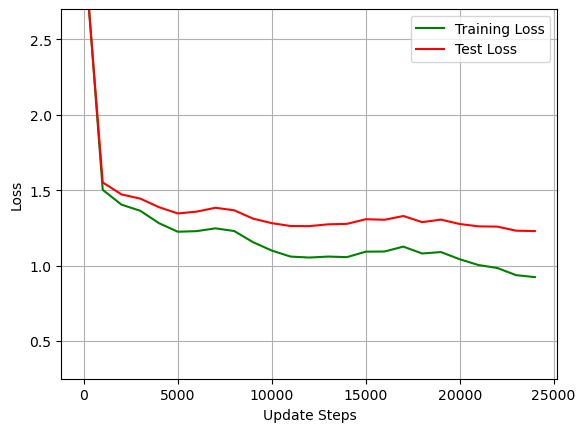

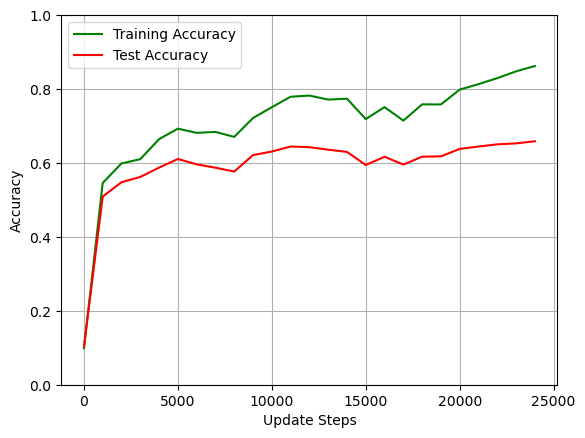


Training time: 1909.74 seconds

Training accuracy: 0.8623061224489796

Validation accuracy: 0.679

Test accuracy: 0.6588


In [73]:
# Label smoothing
Y_train_smooth = smooth_labels(Y_train, eps=0.3)

# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train_smooth, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

## 2) Extensions

### Performance improvement

In [15]:
def pre_compute_flip_indices():
    """
    Pre-compute the flip indices for the images.
    """
    aa = np.int32(np.arange(32)).reshape((32, 1))
    bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
    vv = np.tile(32 * aa, (1, 32))
    
    ind_flip = vv.reshape((32 * 32, 1)) + np.tile(bb, (32, 1))
    inds_flip = np.vstack((ind_flip, 1024 + ind_flip))
    inds_flip = np.vstack((inds_flip, 2048 + ind_flip))
    
    return inds_flip

def pre_compute_shift_indices():
    """
    Pre-compute the shift indices for all (tx, ty) pairs where tx, ty are integers between -3 and +3.
    """
    original_size = 32
    indices_dict = {} 
    for tx in range(-3, 4):
        for ty in range(-3, 4):
            original_indices = []
            new_indices = []
            for channel in range(3): # Iterate over all the dimensions on the image
                for i in range(32):
                    for j in range(32):
                        new_i = i + tx
                        new_j = j + ty
        
                        if 0 <= new_i < 32 and 0 <= new_j < 32:
                            original_index = i + 32 * j + channel * 1024
                            new_index = new_i + 32 * new_j + channel * 1024
        
                            original_indices.append(original_index)
                            new_indices.append(new_index)
        
            original, new = np.array(original_indices).reshape(-1, 1), np.array(new_indices).reshape(-1, 1)

            indices_dict[(tx,ty)] = (original, new)

    return indices_dict

def augmentate_offline(X_train, Y_train, y_train, rng):
    """
    Extend training data once before training by adding shifted / flipped versions of 50% of existing images to the original training dataset.
    """
    n = X_train.shape[-1]
    d = X_train.shape[0]
    n_add = n // 2

    # Precompute flip and shift indices
    inds_flip = pre_compute_flip_indices()
    inds_shift = pre_compute_shift_indices()

    # Generate random translation values
    tx_vals = rng.integers(-3, 4, size=n_add)
    ty_vals = rng.integers(-3, 4, size=n_add)

    # Randomly extract 50% of the training samples to modify them
    selected_indices = rng.choice(n, size=n_add, replace=False)
    X_selected = X_train[:, selected_indices]
    Y_selected = Y_train[:, selected_indices]
    y_selected = y_train[selected_indices]
    
    for i in range(n_add):
        # Flipping
        X_selected[:, i] = X_selected[:, i][inds_flip].flatten()
        
        # Shifting
        tx, ty = tx_vals[i], ty_vals[i]
        indsfill, indsxx = inds_shift[(tx, ty)] # Indices associated with the given t values
        X_selected[:, i][indsfill] = X_selected[:, i][indsxx]

    # Concatenate original and augmented data
    X_augmented = np.concatenate([X_train, X_selected], axis=1)
    Y_augmented = np.concatenate([Y_train, Y_selected], axis=1)
    y_augmented = np.concatenate([y_train, y_selected])
    
    return X_augmented, Y_augmented, y_augmented

def minibatchGD_improved(MX_train, Y_train, y_train, MX_val, Y_val, y_val, GDparams, init_net, lam, rng, eta_decay_factor=None, increase_step=False, plot_per=500, verbose=True, plot_learning=True):
    """
    Perform mini-batch gradient descent with linearly decayed cyclical learning rate.
    """
    n = MX_train.shape[-1] # total number of samples
    n_batch, eta_min, eta_max, n_s, n_cycle = GDparams['n_batch'], GDparams['eta_min'], GDparams['eta_max'], GDparams['n_s'], GDparams['n_cycle']
    n_updates_total = n_s * (2 ** (n_cycle + 1) - 2) if increase_step else 2 * n_s * n_cycle # total number of updates
    n_updates_per_epoch = n // n_batch # number of updates per epoch
    network =  copy.deepcopy(init_net) # network initialization
    t_ranged = 0 # will always stay in range [1, 2 * n_s] to handle the increase of n_s
   
    # Initialize tracking
    train_losses = []  # to store loss
    train_accuracies = []  # to store accuracy
    val_losses = []  # to store validation loss
    val_accuracies = []  # to store validation accuracy
    steps_plot = [] # to store update steps

    for t in range(1, n_updates_total + 1):
        # Reshuffle at the start of each epoch
        if (t - 1) % n_updates_per_epoch == 0:
            shuffled_indices = rng.permutation(n)
            MX_shuffled = MX_train[:, :, shuffled_indices]
            Y_shuffled = Y_train[:, shuffled_indices]

        # Generate a random mini-batch of size n_batch
        j = (t - 1) % n_updates_per_epoch
        j_start = j * n_batch
        j_end = (j + 1) * n_batch
        inds = range(j_start, j_end)
        MX_batch = MX_shuffled[:, :, inds]
        Y_batch = Y_shuffled[:, inds]

        # Forward pass: compute hidden activations and probabilities for the batch samples
        fp_data_batch = forward(MX_batch, network)

        # Backward pass: compute estimations of the gradient based on the batch samples
        grad_batch = backward(MX_batch, Y_batch, fp_data_batch, network, lam)
        
        # Learning rate computation
        # Decaying
        if (t_ranged + 1) % (2 * n_s) == 0 and eta_decay_factor != None:
            eta_max *= eta_decay_factor
        # Step size increasing
        if (t_ranged + 1) % (2 * n_s) == 0 and increase_step: # if a cycle has been achieved and we want n_s to be increased
            n_s *= 2 # doubled after each cycle
            t_ranged = 1 # reset t_ranged
        else:
            t_ranged += 1 # increment t_ranged because the cycle is not finished, or we don't want n_s to be increased
        eta = compute_cyclical_eta(t_ranged, n_s, eta_min, eta_max)

        # Update parameters with cyclical learning rate for each layer separately
        # Fully-connected layers
        for l in range(len(network['W'])):
            network['W'][l] -= eta * grad_batch['W'][l]
            network['b'][l] -= eta * grad_batch['b'][l]

        # Convolutional layer
        network['Fs_flat'] -= eta * grad_batch['Fs_flat']
        network['conv_b'] -= eta * grad_batch['conv_b']
        
        # Compute losses and accuracies with the given period
        if (t == 1 or t % plot_per == 0 or t == n_updates_total) and plot_learning:
            # Compute training loss and accuracy
            P_train = forward(MX_train, network)['P']
            train_loss = compute_loss(P_train, y_train)
            train_acc = compute_accuracy(P_train, y_train)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # Compute validation loss and accuracy
            P_val = forward(MX_val, network)['P']
            val_loss = compute_loss(P_val, y_val)
            val_acc = compute_accuracy(P_val, y_val)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            steps_plot.append(t)

            if verbose:
                print(f"Update step {t} || Training loss = {train_loss} || Training accuracy = {train_acc}")

    if plot_learning:
        # Plot loss over update steps
        plt.plot(steps_plot, train_losses, label='Training Loss', color='g')
        plt.plot(steps_plot, val_losses, label='Test Loss', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.ylim(0.25, 2.7)
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_f{network['f']}_nf{network['Fs_flat'].shape[-1]}_increase{increase_step}_ncycles_{n_cycle}_improved.png", dpi=300)
        plt.show()

        # Plot accuracy over update steps
        plt.plot(steps_plot, train_accuracies, label='Training Accuracy', color='g')
        plt.plot(steps_plot, val_accuracies, label='Test Accuracy', color='r')
        plt.xlabel('Update Steps')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid()
        plt.savefig(f"acc_f{network['f']}_nf{network['Fs_flat'].shape[-1]}increase{increase_step}_ncycles_{n_cycle}_improved.png", dpi=300)
        plt.show()
        
    return network

In [20]:
# Network architecture
f = 4
nf = 60
nh = 300

# Hyper-parameters
n_batch = 100
n_cycle = 5
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Perform offline data augmentation
X_train_augmented, Y_train_augmented, y_train_augmented = augmentate_offline(X_train, Y_train, y_train, rng=rng)

# Compute MX matrices
MX_train_augmented, MX_val, MX_test = compute_MX(X_train_augmented, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

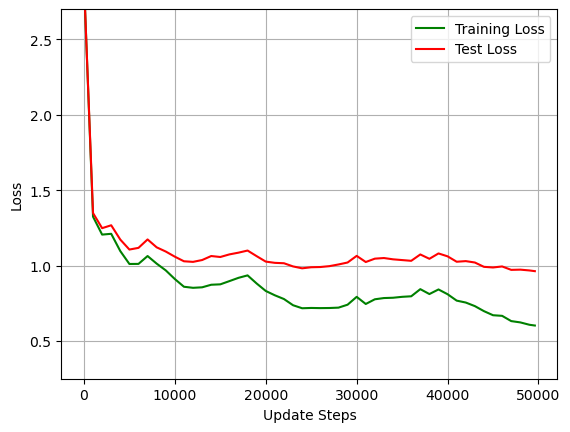

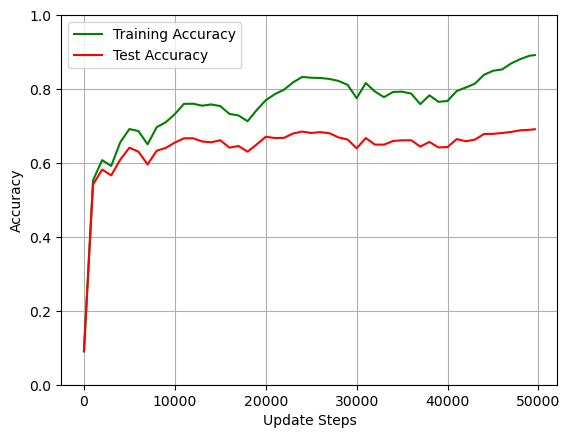


Training time: 6455.87 seconds

Training accuracy: 0.8919727891156463

Validation accuracy: 0.708

Test accuracy: 0.6913


In [22]:
# Label smoothing
Y_train_augmented_smooth = smooth_labels(Y_train_augmented, eps=0.1)

# Training
start_time = time.time()
network = minibatchGD_improved(MX_train_augmented, Y_train_augmented_smooth, y_train_augmented, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, eta_decay_factor=0.9, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train_augmented, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_augmented))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

In [74]:
# Network architecture
f = 4
nf = 60
nh = 400

# Hyper-parameters
n_batch = 100
n_cycle = 4
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.004

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Perform offline data augmentation
X_train_augmented, Y_train_augmented, y_train_augmented = augmentate_offline(X_train, Y_train, y_train, rng=rng)

# Compute MX matrices
MX_train_augmented, MX_val, MX_test = compute_MX(X_train_augmented, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

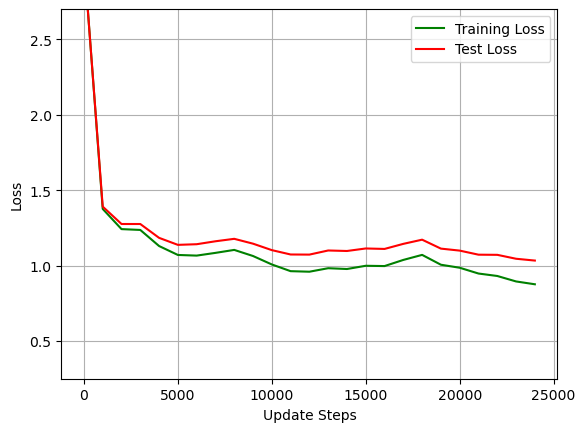

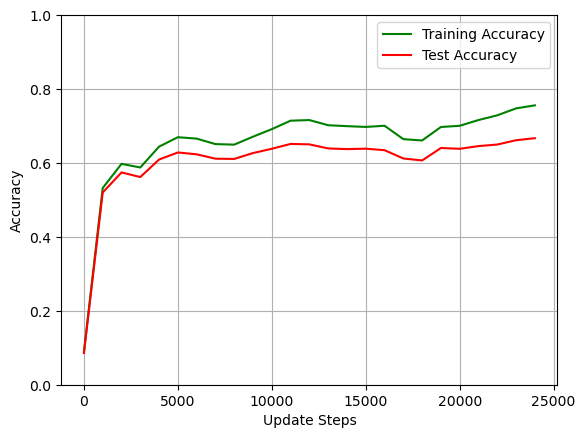


Training time: 3930.50 seconds

Training accuracy: 0.7558775510204082

Validation accuracy: 0.686

Test accuracy: 0.667


In [75]:
# Label smoothing
Y_train_augmented_smooth = smooth_labels(Y_train_augmented, eps=0.1)

# Training
start_time = time.time()
network = minibatchGD_improved(MX_train_augmented, Y_train_augmented_smooth, y_train_augmented, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, eta_decay_factor=0.9, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train_augmented, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_augmented))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

In [79]:
# Network architecture
f = 4
nf = 70
nh = 400

# Hyper-parameters
n_batch = 100
n_cycle = 4
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.002

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Perform offline data augmentation
X_train_augmented, Y_train_augmented, y_train_augmented = augmentate_offline(X_train, Y_train, y_train, rng=rng)

# Compute MX matrices
MX_train_augmented, MX_val, MX_test = compute_MX(X_train_augmented, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

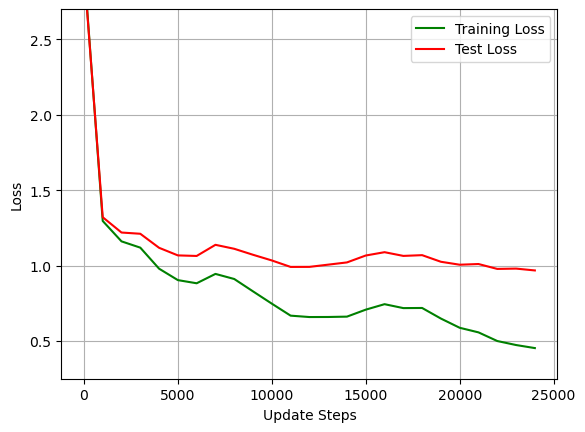

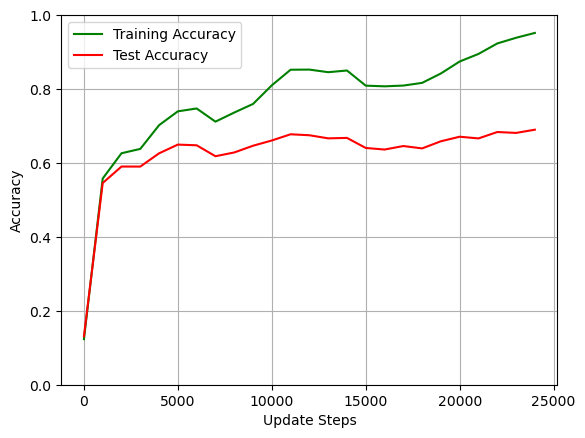


Training time: 6220.94 seconds

Training accuracy: 0.9517959183673469

Validation accuracy: 0.69

Test accuracy: 0.69


In [81]:
# Label smoothing
Y_train_augmented_smooth = smooth_labels(Y_train_augmented, eps=0.1)

# Training
start_time = time.time()
network = minibatchGD_improved(MX_train_augmented, Y_train_augmented_smooth, y_train_augmented, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, eta_decay_factor=0.9, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train_augmented, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_augmented))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

In [19]:
# Network architecture
f = 4
nf = 70
nh = 400

# Hyper-parameters
n_batch = 100
n_cycle = 4
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.003

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Perform offline data augmentation
X_train_augmented, Y_train_augmented, y_train_augmented = augmentate_offline(X_train, Y_train, y_train, rng=rng)

# Compute MX matrices
MX_train_augmented, MX_val, MX_test = compute_MX(X_train_augmented, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

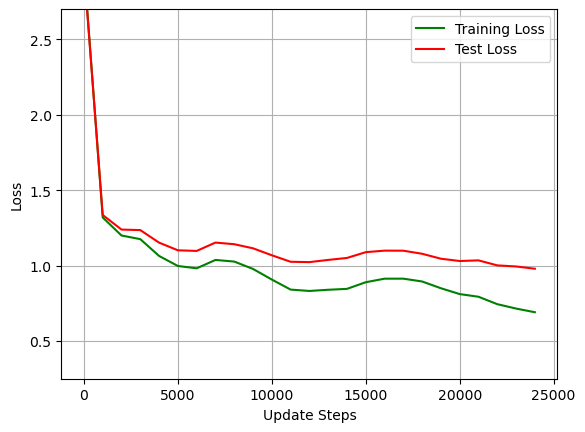

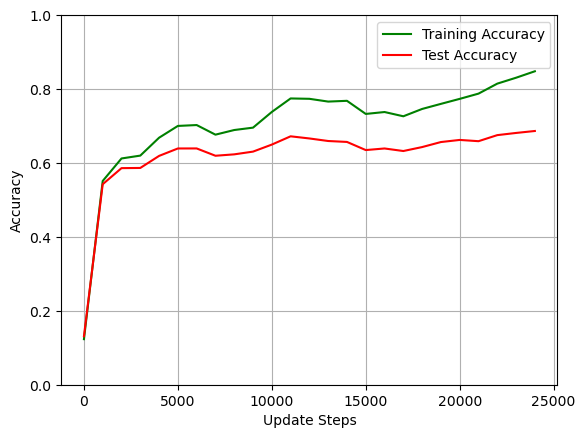


Training time: 5891.94 seconds

Training accuracy: 0.8480816326530612

Validation accuracy: 0.685

Test accuracy: 0.6865


In [21]:
# Label smoothing
Y_train_augmented_smooth = smooth_labels(Y_train_augmented, eps=0.1)

# Training
start_time = time.time()
network = minibatchGD_improved(MX_train_augmented, Y_train_augmented_smooth, y_train_augmented, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, eta_decay_factor=0.9, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train_augmented, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_augmented))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

In [22]:
# Network architecture
f = 4
nf = 70
nh = 450

# Hyper-parameters
n_batch = 100
n_cycle = 4
n_s_1 = 800
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s_1, 'n_cycle':n_cycle}

# Regularization
lam = 0.0035

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Perform offline data augmentation
X_train_augmented, Y_train_augmented, y_train_augmented = augmentate_offline(X_train, Y_train, y_train, rng=rng)

# Compute MX matrices
MX_train_augmented, MX_val, MX_test = compute_MX(X_train_augmented, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

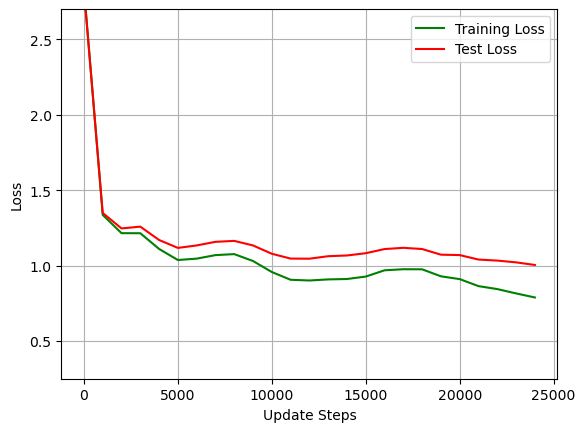

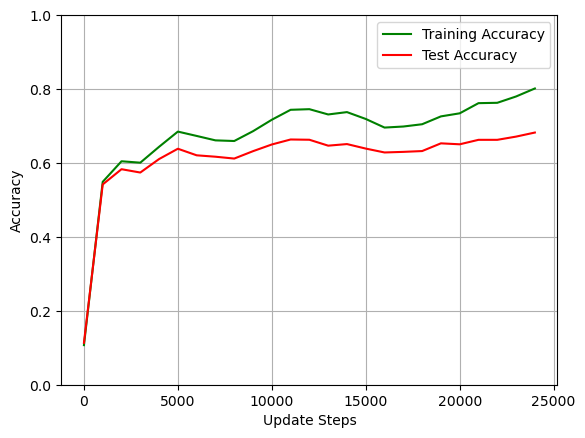


Training time: 5522.97 seconds

Training accuracy: 0.8015238095238095

Validation accuracy: 0.696

Test accuracy: 0.6823


In [23]:
# Label smoothing
Y_train_augmented_smooth = smooth_labels(Y_train_augmented, eps=0.1)

# Training
start_time = time.time()
network = minibatchGD_improved(MX_train_augmented, Y_train_augmented_smooth, y_train_augmented, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, eta_decay_factor=0.9, plot_per=1000, increase_step=True, verbose=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time: {elapsed_time:.2f} seconds")

# Training accuracy
P = forward(MX_train_augmented, network)['P']
print('\nTraining accuracy:', compute_accuracy(P, y_train_augmented))

# Validation accuracy
P = forward(MX_val, network)['P']
print('\nValidation accuracy:', compute_accuracy(P, y_val))

# Test accuracy
P = forward(MX_test, network)['P']
print('\nTest accuracy:', compute_accuracy(P, y_test))

### Compare training time to using PyTorch

In [17]:
class ConvNet(nn.Module):
    def __init__(self, init_net):
        super().__init__()
        
        # Unpack parameters from the initialization network
        self.f = init_net['f'] # filters size 
        self.nf = init_net['Fs_flat'].shape[1] # number of filters
        self.K = init_net['W'][1].shape[0] # number of output classes
        self.nh = init_net['W'][0].shape[0] # hidden layer size

        # Compute number of sub-patches
        self.n_p_y = 32 // self.f
        self.n_p_x = 32 // self.f
        self.n_p = self.n_p_y * self.n_p_x

        # Register convolution weights (reshape flat weights to 4D conv filter)
        fs_reshaped = init_net['Fs_flat'].T.reshape(self.nf, 3, self.f, self.f)
        self.weight = nn.Parameter(torch.tensor(fs_reshaped, dtype=torch.float32, requires_grad=True))
        self.bias = nn.Parameter(torch.tensor(init_net['conv_b'].squeeze(), dtype=torch.float32, requires_grad=True))

        # Register fully-connected weights and biases
        W0 = torch.tensor(init_net['W'][0], dtype=torch.float32, requires_grad=True)
        b0 = torch.tensor(init_net['b'][0].squeeze(), dtype=torch.float32, requires_grad=True)
        W1 = torch.tensor(init_net['W'][1], dtype=torch.float32, requires_grad=True)
        b1 = torch.tensor(init_net['b'][1].squeeze(), dtype=torch.float32, requires_grad=True)
        self.fc1_W = nn.Parameter(W0)
        self.fc1_b = nn.Parameter(b0)
        self.fc2_W = nn.Parameter(W1)
        self.fc2_b = nn.Parameter(b1)

    def forward(self, X):
        # Convolutional layer
        H = F.conv2d(X, self.weight, self.bias, stride=self.f)
        H = F.relu(H)

        # Flatten the conv output for FC layers
        h = H.view(H.size(0), -1)  # shape: (batch_size, nf * n_p)

        # First fully connected layer
        X1 = F.linear(h, self.fc1_W, self.fc1_b)
        X1 = F.relu(X1)

        # Second fully connected layer
        S = F.linear(X1, self.fc2_W, self.fc2_b)

        # Output
        P  = F.softmax(S, dim=1)
        
        return P

    def train_net(self, X_train, Y_train, GDparams, verbose=False):
        # Hyperparameters
        n = X_train.shape[0]  # total number of samples
        n_batch, eta_min, eta_max, n_s, n_cycle = GDparams['n_batch'], GDparams['eta_min'], GDparams['eta_max'], GDparams['n_s'], GDparams['n_cycle']
        n_updates_total = n_s * n_cycle * 2  # total number of updates
        n_updates_per_epoch = n // n_batch  # number of updates per epoch
        n_epoch = n_updates_total // n_updates_per_epoch  # number of epochs
        network = copy.deepcopy(init_net)  # network initialization
    
        # Create dataset and dataloader
        dataset = TensorDataset(X_train, Y_train)
        loader = DataLoader(dataset, batch_size=n_batch, shuffle=True)
    
        # Create SGD optimizer
        optimizer = optim.SGD(self.parameters(), lr=eta_min)
    
        # Cyclic LR scheduler
        scheduler = optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=eta_min,
            max_lr=eta_max,
            step_size_up=n_s,
            mode='triangular',
            cycle_momentum=False
        )
    
        # Tracking metrics
        losses = []
        accuracies = []
    
        # Training loop
        for epoch in range(n_epoch):
            epoch_loss = 0.0
            correct_preds = 0
            total_preds = 0
            
            # Mini-batch loop
            for X_batch, Y_batch in loader:
                # Zero gradients
                optimizer.zero_grad()
    
                # Forward pass
                P_batch = self.forward(X_batch)
    
                # Compute loss
                loss = torch.mean(-torch.log(P_batch[np.arange(len(Y_batch)), Y_batch]))
    
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
    
                # Update the learning rate with scheduler
                scheduler.step()

                if verbose:
                    epoch_loss += loss.item() * X_batch.size(0)  # sum loss
                    P = self.forward(X_batch)
                    _, pred = torch.max(P, dim=1)
                    correct_preds += (pred == Y_batch).sum().item()
                    total_preds += 1

            if verbose:
                # Normalize and store metrics (estimated on the batch)
                avg_loss = epoch_loss / n
                accuracy = correct_preds / total_preds
        
                losses.append(avg_loss)
                accuracies.append(accuracy)
    
                print(f"Epoch {epoch+1} || Training loss: {avg_loss} || Training accuracy: {accuracy}")

Architecture 1:

In [80]:
# Network architecture
f = 2
nf = 3
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [88]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 93.99 seconds

Training time for the PyTorch network: 87.41 seconds


Architecture 2:

In [90]:
# Network architecture
f = 4
nf = 10
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [91]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 96.16 seconds

Training time for the PyTorch network: 81.48 seconds


Architecture 3:

In [95]:
# Network architecture
f = 8
nf = 40
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [96]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 99.18 seconds

Training time for the PyTorch network: 86.62 seconds


Architecture 4:

In [45]:
# Network architecture
f = 16
nf = 160
nh = 50

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [46]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 132.93 seconds

Training time for the PyTorch network: 114.21 seconds


Architecture 5:

In [48]:
# Network architecture
f = 4
nf = 10
nh = 100

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [49]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 100.29 seconds

Training time for the PyTorch network: 129.95 seconds


Architecture 6:

In [51]:
# Network architecture
f = 4
nf = 10
nh = 200

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [52]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 117.75 seconds

Training time for the PyTorch network: 229.58 seconds


Architecture 7:

In [54]:
# Network architecture
f = 16
nf = 160
nh = 200

# Hyper-parameters
n_batch = 100
n_cycle = 3
n_s = 980
eta_min = 1e-5
eta_max = 1e-1
GDparams = {'n_batch':100, 'eta_min': eta_min, 'eta_max':eta_max, 'n_s':n_s, 'n_cycle':n_cycle}

# Regularization
lam = 0.0

# Initialize network
rng = np.random.default_rng(seed=42)
init_net = initialize_net_he(nf=nf, f=f, nh=nh, rng=rng)

# Compute MX matrices
MX_train, MX_val, MX_test = compute_MX(X_train, f).astype(np.float32), compute_MX(X_val, f).astype(np.float32), compute_MX(X_test, f).astype(np.float32)

# Reshape and convert data for PyTorch conv2d
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
X_train_tensor = X_train_tensor.T
X_train_tensor = X_train_tensor.view(-1, 3, 32, 32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [55]:
# My network
# Training
start_time = time.time()
network = minibatchGD(MX_train, Y_train, y_train, MX_test, Y_test, y_test, GDparams, init_net, lam, rng=rng, plot_learning=False)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for my network: {elapsed_time:.2f} seconds")


# PyTorch network
# Instantiate model on CPU
network = ConvNet(init_net).to("cpu")

# Training
start_time = time.time()
network.train_net(X_train_tensor, Y_train_tensor, GDparams)
end_time = time.time()

# Training time
elapsed_time = end_time - start_time
print(f"\nTraining time for the PyTorch network: {elapsed_time:.2f} seconds")


Training time for my network: 149.57 seconds

Training time for the PyTorch network: 258.18 seconds
